# Get The Data
Download CIFAR10 dataset and load it.
I've loaded it as batches of 2, 4, and 6 to compare the differences in speed, and to see how this might affect the accuracy when training.

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T

cifar10_dataset = datasets.CIFAR10(root='./', # here
                               train=True, # train split
                               download=True, # we want to get the data
                               transform=T.ToTensor(), # put it into tensor format
                              )

train_data_bs2 = DataLoader(cifar10_dataset,
                                    batch_size=2,
                                    )

train_data_bs4 = DataLoader(cifar10_dataset,
                                    batch_size=4
                                    )

train_data_bs6 = DataLoader(cifar10_dataset,
                                    batch_size=6
                                    )

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


In [29]:
len(train_data_bs4)

12500

# Investigate the data
We don't actually know anything about our data, so let's see how it looks.

In [30]:
data = iter(train_data_bs6) # Let's iterate on it
single_point = next(data)
print(f"""Type: {type(single_point)}
Length: {len(single_point)}
More Types: {type(single_point[0])}, {type(single_point[1])}
Shapes: {single_point[0].shape}, {single_point[1].shape}
Labels: {single_point[1]}
""")

Type: <class 'list'>
Length: 2
More Types: <class 'torch.Tensor'>, <class 'torch.Tensor'>
Shapes: torch.Size([6, 3, 32, 32]), torch.Size([6])
Labels: tensor([6, 9, 9, 4, 1, 1])



We here can see that the dataloader gives us back a list `(data, label)`. We can see that both are tensors (thanks to our transform we did) and we can see the shapes. We know that the label tensor is corresponding answers. The data tensor is shaped in `batch, channel, height, width`. That's because it is image data (and we have some prior knowledge)

Let's also look at the data tensor we have `single_point[0]` (note that matplotlib by default will not use grayscale but viridis colormap. It is still a single channel but with higher readability)

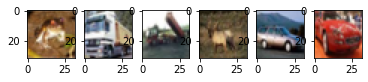

In [34]:
import matplotlib.pyplot as plt
from torchvision import transforms as T
ToPIL = T.ToPILImage() # Converting function
img0 = ToPIL(single_point[0][0])
img1 = ToPIL(single_point[0][1])
img2 = ToPIL(single_point[0][2])
img3 = ToPIL(single_point[0][3])
img4 = ToPIL(single_point[0][4])
img5 = ToPIL(single_point[0][5])
# Plotting
fig, axs = plt.subplots(1,6)
axs[0].imshow(img0)
axs[1].imshow(img1)
axs[2].imshow(img2)
axs[3].imshow(img3)
axs[4].imshow(img4)
axs[5].imshow(img5)



```
# This is formatted as code
```

# Part 1 - Linear Classifier



In [7]:
from torch import nn

class Classifier(nn.Module):
    def __init__(self,
                 ninputs=3*32*32, # Size of input (channels * size of image)
                 nhidden=512, # Number of hidden layers
                 nout=10, # Number of classes
                ):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(ninputs, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nout),
            nn.ReLU(),
        )
        
    def forward(self, x):
        b, c, h, w = x.shape
        x = x.view(b, -1) # Flatten image -- 3 * 32 * 32
        x = self.net(x)
        return x

In [ ]:
class resnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequntial(nn.Linear(10,10), nn.ReLU())
        self.l2 = nn.Sequntial(nn.Linear(10, 10), nn.ReLU())
        
    def forward(self, x):
        skip = x
        x = self.l1(x)
        x = skip + x
        x = self.l2(x)
        return x

# Setup the training program
Now we need to get the meat of the subject and get the parts we need to train the network.

In [8]:
import torch
from torchvision import datasets
from torch import nn
from torch import optim
from tqdm import tqdm, notebook # This is optional but useful

# Let's get the right torch device (preference of GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Let's set up some parameters
learning_rate=5e-1
nepochs = 10
ninputs=3*32*32
nhidden=1024
nout=10

model = Classifier(ninputs=ninputs,
                  nhidden=nhidden,
                  nout=nout).to(device)
print(model)
# We need an optimizer that tells us what form of gradient descent to do
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# We also need a loss function
LossFunction = nn.CrossEntropyLoss()

# We're going to reload the data here so we have added clarity

batch_size = 2048

cifar10_dataset = datasets.CIFAR10(root='./', # here
                               train=True, # train split
                               download=True, # we want to get the data
                               transform=T.ToTensor(), # put it into tensor format
                              )

train_data = DataLoader(cifar10_dataset,
                            batch_size=batch_size,
                            )

# This is default on but let's just be pedantic
model.train()
loss_history = []
loss = torch.Tensor([0])
for epoch in notebook.trange(nepochs,
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
    for (data, label) in tqdm(train_data,
                              desc="iteration",
                              unit="%",
                              disable=True):
        optimizer.zero_grad(set_to_none=True) # Here we clear the gradients
        
        # We need to make sure the tensors are on the same device as our model
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        
        loss = LossFunction(out, label)
        
        # PyTorch is Magic!
        loss.backward() # This function calculates all our gradients
        optimizer.step() # This function does our gradient descent with those gradients
        loss_history.append(loss.item())
    print(f"Epoch {epoch}: loss: {loss.item()}")


KeyboardInterrupt: ignored

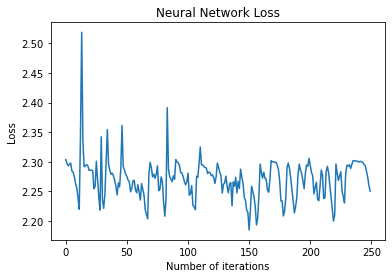

In [42]:
# Note that we are not plotting loss per epoch but per iteration
plt.plot(loss_history)
plt.title("Neural Network Loss")
plt.xlabel("Number of iterations")
plt.ylabel("Loss")
plt.show()

# Testing
Now lets' see how well our network learned



In [9]:
# We need to do the test data now
mnist_test_dataset = datasets.CIFAR10(root='./', # here
                               train=False, # train split
                               download=True, # we want to get the data
                               transform=T.ToTensor(), # put it into tensor format
                              )
test_data = DataLoader(mnist_test_dataset,
                       batch_size=batch_size,
                        )

model.eval()
accuracy = 0
for (data, label) in test_data:
    data = data.to(device)
    label = label.to(device)
    out = model(data)
    answers = out.max(dim=1)[1]
    accuracy += (answers == label).sum()
print(f"Total accuracy = {accuracy / len(mnist_test_dataset)*100:.2f}%")

Files already downloaded and verified


NameError: ignored

# Summary
You should play around with the above network and test different hyper parameters. Does the accuracy change? 

Try to answer the following questions:
- How does Learning Rate change the accuracy?
- How does batch size change things?
- How many hidden layers do we need?
- What happens if we use a different loss function?
- What about a different optimizer?
- Do we need to train longer?

# Getting more advanced
Let's get a bit more advanced with our network. This time we will design our network to take a variable number of hidden layers. We'll be able to add more depth to the network and define how many hidden layers are in that layer.

In [10]:
class LinearNet(nn.Module):
    def __init__(self,
                 ninputs=3*32*32,
                 hidden=[512],
                 nout=10,
                ):
        super().__init__()
        net = []
        # Input layer
        net.append(nn.Linear(ninputs, hidden[0]))
        net.append(nn.ReLU())
        
        # Hidden layers
        """if len(hidden) > 1:
            for i in range(len(hidden)):
                if i == 0:
                    net.append(nn.Linear(hidden[i], hidden[i+1]))
                else:
                    net.append(nn.Linear(hidden[i-1], hidden[i]))
                net.append(nn.ReLU())"""
        if len(hidden) > 1:
          for i in range(len(hidden) - 1):
            net.append(nn.Linear(hidden[i], hidden[i+1]))
            net.append(nn.ReLU())

        # Output Layer
        net.append(nn.Linear(hidden[-1], nout))
        net.append(nn.ReLU())
        self.net = nn.Sequential(*net)
        
    def forward(self, x):
        b, c, h, w = x.shape
        x = x.view(b, -1) # Flatten image
        x = self.net(x)
        return x

In [11]:
# Let's set up some parameters
learning_rate=5e-1
nepochs = 10
ninputs=3*32*32
hidden=[5000, 10000]
nout=10

model = LinearNet(ninputs=ninputs,
                  hidden=hidden,
                  nout=nout).to(device)
print(model)
# We need an optimizer that tells us what form of gradient descent to do
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# We also need a loss function
LossFunction = nn.CrossEntropyLoss()

# We're going to reload the data here so we have added clarity

batch_size = 2048

cifar10_dataset = datasets.CIFAR10(root='./', # here
                               train=True, # train split
                               download=True, # we want to get the data
                               transform=T.ToTensor(), # put it into tensor format
                              )

train_data = DataLoader(cifar10_dataset,
                        batch_size=batch_size,
                        )

# This is default on but let's just be pedantic
model.train()
loss_history = []
for epoch in notebook.trange(nepochs,
                  desc="Epoch",
                  unit="epoch",
                  disable=False):
    for (data, label) in tqdm(train_data,
                              desc="iteration",
                              unit="%",
                              disable=True):
        optimizer.zero_grad(set_to_none=True)
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        loss = LossFunction(out, label)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
    print(f"Epoch {epoch}: loss: {loss.item()}")
    
# Note that we are not plotting loss per epoch but per iteration
plt.plot(loss_history)
plt.title("Neural Network Loss")
plt.xlabel("Number of iterations")
plt.ylabel("Loss")
plt.show()

LinearNet(
  (net): Sequential(
    (0): Linear(in_features=3072, out_features=5000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5000, out_features=10000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10000, out_features=10, bias=True)
    (5): ReLU()
  )
)
Files already downloaded and verified


Epoch:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 0: loss: 2.288611888885498
Epoch 1: loss: 2.300048589706421
Epoch 2: loss: 2.271409273147583
Epoch 3: loss: 2.2844483852386475
Epoch 4: loss: 2.2577197551727295
Epoch 5: loss: 2.2283008098602295
Epoch 6: loss: 2.2496776580810547
Epoch 7: loss: 2.2545254230499268
Epoch 8: loss: 2.206313371658325
Epoch 9: loss: 2.2268693447113037


NameError: ignored

In [ ]:
model.eval()
accuracy = 0
for (data, label) in test_data:
    data = data.to(device)
    label = label.to(device)
    out = model(data)
    answers = out.max(dim=1)[1]
    accuracy += (answers == label).sum()
print(f"Total accuracy = {accuracy / len(mnist_test_dataset)*100:.2f}%")

# Getting More Out of PyTorch

In [ ]:
# Let's see what datasets are offered (https://pytorch.org/vision/stable/datasets.html)
print(datasets.__dir__())

In [ ]:
# What about optimizers?
print(optim.__dir__())

['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__path__', '__file__', '__cached__', '__builtins__', 'Adadelta', 'Adagrad', 'Adam', 'AdamW', '_functional', 'SparseAdam', 'Adamax', 'ASGD', 'SGD', 'RAdam', 'Rprop', 'RMSprop', 'Optimizer', 'NAdam', 'LBFGS', 'lr_scheduler', 'swa_utils', '_multi_tensor']
